Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат


In [1]:
!pip install lightgbm

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier


import shap


In [3]:
df = pd.read_csv('churn_data.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'Geography'], inplace=True)
df.Gender = df.Gender.apply(lambda x: 0 if x == 'Female' else 1)
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,42,2,0.00,1,1,1,101348.88,1
1,608,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,39,1,0.00,2,0,0,93826.63,0
4,850,0,43,2,125510.82,1,1,1,79084.10,0


Поглядим на целевую переменную:

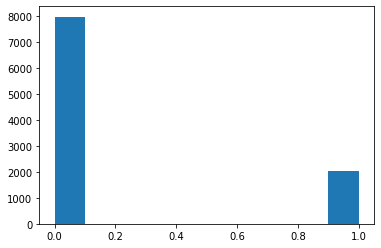

In [5]:
plt.hist(df.Exited);

In [6]:
df.Exited.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

И на остальные переменные:

<AxesSubplot:>

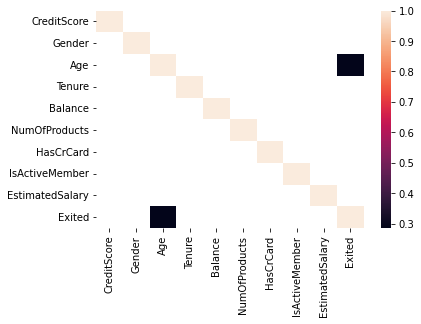

In [7]:
sns.heatmap(df.corr()[df.corr() > 0.2])

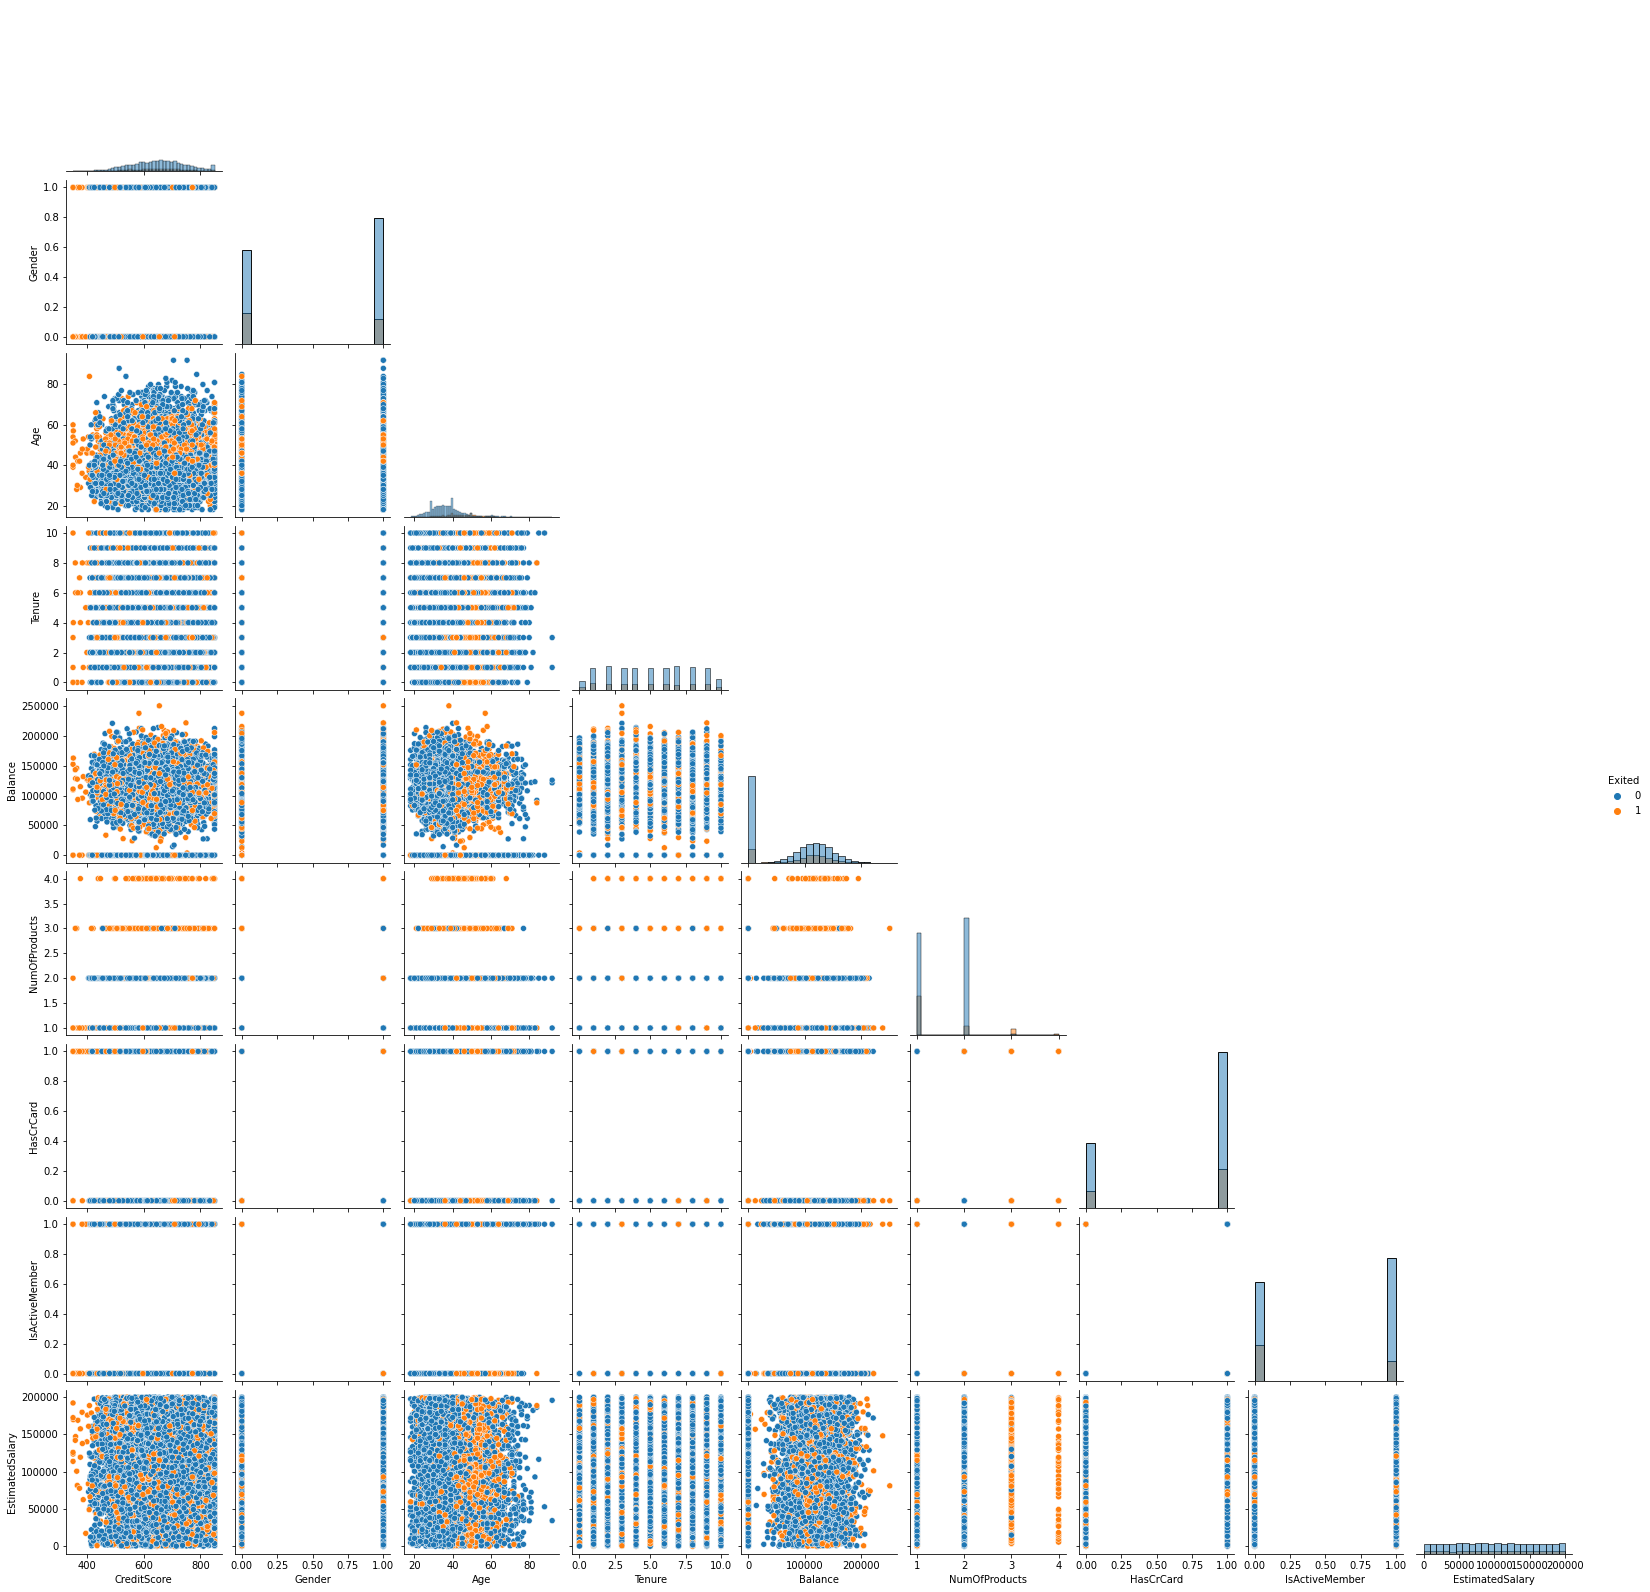

In [8]:
sns.pairplot(df, hue='Exited', corner=True, height=2.5, diag_kind='hist')

In [9]:
X = df.drop(columns=['Exited'])
y = df.Exited
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

### 4. Обучить любой классификатор (какой вам нравится)

In [10]:
lgb_model = LGBMClassifier(random_state=1)
lgb_model.fit(X_train, y_train)

y_preds = lgb_model.predict(X_test)


### 5. разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


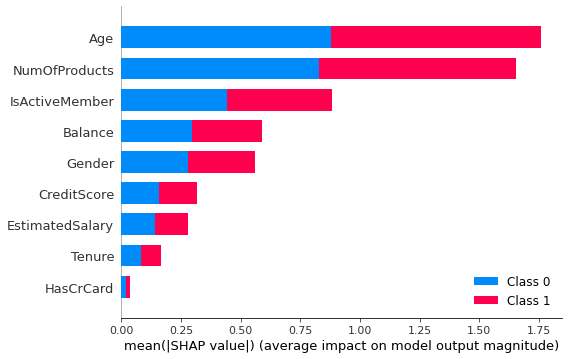

In [11]:
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test)

shap.initjs() 
shap.summary_plot(shap_values, X_test)

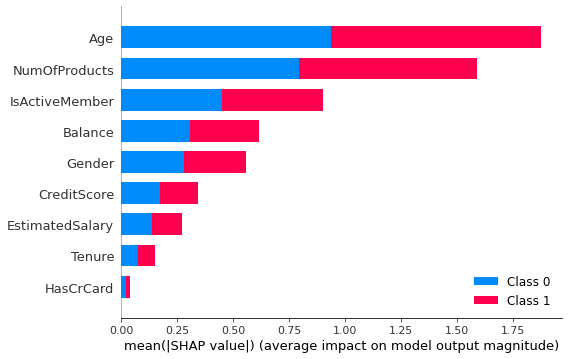

In [12]:
top_ten = y_test.shape[0]//10
shap_values = explainer.shap_values(X_test[:top_ten])

shap.initjs() 
shap.summary_plot(shap_values, X_test[:top_ten])

Картина важности признаков не меняется.

### 6. Для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

In [13]:
shap_values = explainer.shap_values(X_test)
shap_values_all = explainer.shap_values(X_train)

In [14]:
shap_values = shap_values[1]
shap_values_all = shap_values_all[1]

Без этой строчки не заработает:

In [15]:
explainer = shap.TreeExplainer(lgb_model,data=df)

In [17]:
shap.initjs()
idx = 10
shap.force_plot(explainer.expected_value, shap_values_all[idx,:], features=X_train.iloc[idx,:])

Пользователь, скорее всего, не пойдет в отток:  
    1. Он в нужной возрастной группе (молодой)  
    2. Он участвует в программах лояльности  
    3. Он мужчина    
  
Факторы риска, такие, как небольшое количество открытых продуктов (1) и существенная сумма на балансе, не оказывают такого существенного влияния на вероятность оттока.